# Laboratory exercise: Classification

In this laboratory exercise we will apply classification and regression algorithms over a synthetic dataset.


## Data load.

Load the data variables from the npz file provided with this exercise

In [44]:
import numpy as np
from sklearn.metrics import accuracy_score
import sklearn

# Load data from file 10012345.mat .
data = np.load('10012345.npz')

xRtrain = data['xRtrain']
xRtrainLost = data['xRtrainLost']
xRval = data['xRval']
sRtrain = data['sRtrain']
sRval = data['sRval']
xCtrain = data['xCtrain']
xCval = data['xCval']
yCtrain = data['yCtrain']
yCval = data['yCval']

Initialize all requested variables to 0.

In [45]:
# Classification:
w_full, e_full, p20, emin, nvar, wmin, cv0, rp_opt, fpr = 0, 0, 0, 0, 0, 0, 0, 0, 0
# Regression:
wML, AAE, NLL, wmean, Vw = 0, 0, 0, 0, 0


## Part 1: Clasification

Each of the data matrices `xCtrain` and `xCval` contains 240 data vectors with dimension $D=5$. 

Assume that the binary labels `yCtrain` and `yCval` (with values in {0, 1}) were generated according to a logistic regression model:
$$p(y = 1 | {\bf w}, {\bf x}) = \frac{1}{1 + \exp(-{\bf w}^T {\bf z})}$$
where  
$$
{\bf z} = \begin{pmatrix} 1 \\ {\bf x} \end{pmatrix}
$$

### Exercise C0 [extra]:

Normalize the input matrices in such a way that each feature has zero mean and unit standard deviation. You can do it using standard python commands or by means of the `preprocessing.StandardScaler` from `sklearn`. Use `xCtrain` to estimate the mean and variance of each feature, and make sure that the same normalization is applied to any input, ${\bf x}$, no matter if it belogs to the training or the validation set.

Store the normalized matrices in the same variables, `xCtrain`and `xCval`.

In [46]:
# Write your code here.
# <SOL>
# </SOL>    
# mean_R = np.mean(xRtrain, axis=0)
# std_R = np.std(xRtrain, axis=0)
# Xtrain = (xRtrain - mean_R) / std_R
# xRtrainLost = (xRtrainLost - mean_R) / std_R
# xRval = (xRval - mean_R) / std_R

# mean_R = np.mean(xRtrain, axis=0)
# std_R = np.std(xRtrain, axis=0)
# XCrain = (xCtrain - mean_R) / std_R
# xCval = (xCval - mean_R) / std_R
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# Initialize the StandardScaler
scaler = StandardScaler()
scaler2 = StandardScaler()
# Fit the scaler to the training data and transform it
xCtrain_norm = scaler.fit_transform(xCtrain)
xRtrain = scaler2.fit_transform(xRtrain)

# You can use the same scaler to normalize any validation set to ensure consistency
xCval_norm= scaler.transform(xCval)  # Replace with your validation data
xRval = scaler2.transform(xRval)

xCtrain = np.hstack((np.ones((xCtrain_norm.shape[0], 1)), xCtrain_norm))
xCval = np.hstack((np.ones((xCval_norm.shape[0], 1)), xCval_norm))

print(xCtrain_norm.shape)


(240, 5)


### Exercise C1:

As a preliminary task, fit a logistic regression model using the training data available in `xCtrain` and `yCtrain`, using the implementation available from `sklearn`. Use regularization parameter $C=2$, set the `random_state` to 42 and use the default values for all other arguments. 

Store the resulting weight vector in the variable `w_full`.


In [47]:
# Write your code here.

#<SOL>
#</SOL>
model = LogisticRegression(C=2, random_state=42, fit_intercept=False)
w_full = model.fit(xCtrain, yCtrain).coef_[0]#Porque es binario
print(w_full)

[ 0.02930159 -0.12589863  1.15997047 -0.15528534  0.71331906  0.27936377]


### Exercise C2.

Determine the classification error rate measured on the validation data (`xCval` and `yCval`). Store the error rate in the variable `e_full`.

In [48]:
# Write your code here.
#<SOL>
# </SOL>
# Predecir las etiquetas para los datos de validación
yCval_pred = model.predict(xCval)

# Calcular la tasa de error de clasificación
e_full = np.mean(yCval_pred != yCval)
# Print the error rate.
print(e_full)

0.25104166666666666


### Exercise C3

Determine the probability that the $k$-th sample in the validation set belongs to category  $y_k = 1$, according to the model computed in exercise 1, for $k = 0, 1, \dots, 19$. Store the result in the variable `p20`.



In [49]:
# Write your code here
# <SOL>
# </SOL>
K = 20

probas = model.predict_proba(xCval)

probas_y1 = probas[:, 1]
p20 = probas_y1[:20]  


# Print the probabilities.
print(p20)

[0.88394365 0.28847106 0.08091301 0.0258122  0.87142269 0.84381446
 0.19677792 0.33481932 0.41210246 0.23977197 0.23093801 0.41438111
 0.15926061 0.16408098 0.86420816 0.19535421 0.28271016 0.28848939
 0.02786647 0.39428892]


### Exercise C4.

It is known that all coefficients  $w_i$  (with  $i > n$) are zero, that is, all variables $x_{n+1}, \dots, x_{D-1}$ are irrelevant for the classification task, but the value of $n$ is unknown. Consequently, the goal is to fit a model that includes only the relevant variables:

Train $D$ different logistic regression models, starting with the model that uses only the first variable, and adding one variable at a time, so that the $i$-th model will use only the variables $x_0, x_1, \dots, x_{i-1}$.  Using $C=2$, `random_state`=42 and all other default parameters.

For each model, compute the classification error rate (on the validation data), and keep the best result. 

Store the following variables:

  * `emin`: the lowest validation error
  * `nvar`: an integer indicating the number of variables in the model, 
  * `wmin`: the corresponding weight vector (only for the best case).



In [50]:
# Write your code here.
#<SOL>
#</SOL>

emin = float('inf') 
nvar = 0              
wmin = None           

D = xCtrain.shape[1] 

for i in range(1, D + 1):  
    x_train_subset = xCtrain[:, :i]
    x_val_subset = xCval[:, :i]

    model = LogisticRegression(C=2, random_state=42, fit_intercept=False)
    model.fit(x_train_subset, yCtrain)

    y_val_pred = model.predict(x_val_subset)

    error_rate = 1 - model.score(x_val_subset, yCval)  
    print(error_rate)
    if error_rate < emin:
        emin = error_rate
        nvar = i
        wmin = model.coef_[0]  # Guardar el vector de pesos

# Print the results.
print(f"emin = {emin}")
print(f"nvar = {nvar}")
print(wmin)

0.4864583333333333
0.4697916666666667
0.2833333333333333
0.2822916666666667
0.2510416666666667
0.2510416666666667
emin = 0.2510416666666667
nvar = 5
[ 0.03084771 -0.13571241  1.16055007 -0.15423423  0.7210371 ]


### Exercise C5 [extra].

In this exercise we will train a classifier based on **quadratic discriminant analysis**, using the appropriate class from `sklearn`.

The algorithm has a regularization parameter, `reg_param`, that must take some value between 0 and 1. We will select the appropriate value by means of 10-fold cross validation. As a validation metric, we will use the <a href=https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score>F1-score</a>.

To do so:

  1. Join the train and validation sets into a single dataset, by stacking matrices `xCtrain` (on top) and `xCval` (down) into a single matrix `xCV`. In a similar way, join labels into aarray `yV`.
  2. Using the CV dataset and the `cross_val_score` method from `sklearn.model_selection`, compute the cross validation F1-score (averaged over all folds), for `reg_param=0`. Save the result in variable `cv0`
  3. Select the best value of `reg_param` in $\{0, 0.1, 0.2, 0.3, \ldots, 1.0\}$ by 10-fold cross validation, according to the F1-score. Save the result in variable `rp_opt`.


In [63]:
# Write your code here.
#<SOL>
#</SOL>
# print(xCtrain.size)
# print(len(xCtrain))
# print(xCval.size)
# print(len(yCtrain))
import sklearn.metrics
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, f1_score
model = QuadraticDiscriminantAnalysis(reg_param=0)
xCV = np.vstack((xCtrain,xCval))
yV = np.hstack((yCtrain,yCval))
scorer = make_scorer(f1_score)
cv0 = np.mean(cross_val_score(model, xCV, yV, cv = 10, scoring = scorer))

best_score = -np.inf  
rp_opt = 0 

for rp in np.arange(0,1.1,0.1):
    model = QuadraticDiscriminantAnalysis(reg_param=rp)
    cv_score = np.mean(cross_val_score(model, xCV, yV, cv = 10, scoring = scorer))
    print(rp)
    print(cv_score)
    if cv_score > best_score:
        best_score = cv_score
        rp_opt = rp

# Print the results.
print(f"cv0 = {cv0}")
print(f"rp_opt = {rp_opt}")

(240, 6)
(240,)
(1200,)
0.0
0.0
0.1
0.7520529343472969
0.2
0.7514244975837462
0.30000000000000004
0.7500788396669354
0.4
0.750061549997822
0.5
0.7506710738073459


c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:972: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:972: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:975: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda

0.6000000000000001
0.7526142888404695
0.7000000000000001
0.7539991221650565
0.8
0.7560250868037961
0.9
0.7570186351908927
1.0
0.7539671338617968
cv0 = 0.0
rp_opt = 0.9


c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\

### Exercise C6 [extra].

Take the regularization parameter selected in C5, train the quadratic discriminant using `xCtrain`and `yCtrain`, and compute the false positive rate (i.e. the ratio of false positives vs the total number of negatie samples) of the classifier over the validation set. Save the result in variable `fpr`.

[[343 124]
 [117 376]]
0.26552462526766596


c:\Users\ruben\anaconda3\envs\Tratamientodedatos\Lib\site-packages\sklearn\discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


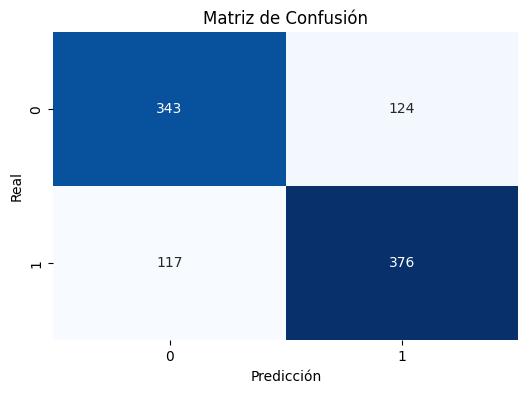

In [52]:
# Write your code here.
#<SOL>
#</SOL>
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
model = QuadraticDiscriminantAnalysis(reg_param=rp_opt)
model.fit(xCtrain,yCtrain)
y_pred = model.predict(xCval)

tn, fp, fn, tp = confusion_matrix(yCval, y_val_pred).ravel()
print(confusion_matrix(yCval, y_val_pred))
# Calcular la tasa de falsos positivos (False Positive Rate, FPR)
fpr = fp / (fp + tn)

# Print the false positive rate.
print(fpr)

cm = confusion_matrix(yCval, y_val_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

# Añadir etiquetas y título
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Real')

# Mostrar la gráfica
plt.show()

## Part 2: Regression

The mentioned variables include a training set consisting of 300 data points, each consisting of input-output pairs:  $D = \{{\bf x}_k, s_k\}_{k=0}^{299}$. The input vectors are provided as the rows of the variable `xRtrain`, while their corresponding labels are available in the vector `sRtrain`. Use these variables as provided, without applying any normalization procedure.

Assume the data were generated according to the following model:
$$
s = w_0 + w_1 x_0 + w_2 x_2^3 + w_3 \exp(x_4) + \varepsilon
$$
where the noise samples follow a Gaussian distribution with zero mean and variance $\sigma^2_{\varepsilon} = 0.4$.

### Exercise R1

Obtain the maximum likelihood estimator of the model. Store your result in the variable `wML`.


In [53]:
xRtrain.shape

(300, 5)

In [54]:
# Write your code here.
#<SOL>
#</SOL>
import numpy as np
from sklearn.linear_model import LinearRegression
l = len(xRtrain)
x0 = xRtrain[:, 0]
x2 = xRtrain[:, 2]**3
x4 = np.exp(xRtrain[:, 4])

Z = np.column_stack((np.ones(l), x0, x2, x4))


model = LinearRegression(fit_intercept=False) #sE PUEDE HACER POR FORMULA
model.fit(Z, sRtrain)


wML = model.coef_

# Se puede hacer también por minimos cuadrados
# wML = np.linalg.lstsq(Z, sRtrain)[0]

# Print the result.
print(wML)                    

[-0.22827806  0.19852257  0.01735276  0.04003244]


### Exercise R2

For the previously obtained estimator, determine the average absolute error on the training dataset, i.e.,
$$
\text{AAE} = \frac{1}{N} \sum_{i=1}^{N} |s(i) - \hat{s}(i)|
$$
where  N  is the number of training data points. Store your result in the variable AAE.


In [55]:
# Write your code here.
#<SOL>
#</SOL>
s_train_pred = Z.dot(wML)

N = len(sRtrain) 
AAE = np.sum(np.abs(sRtrain - s_train_pred)) / N
# Print the result.
print(AAE)

0.8177666501366135


### Exercise R3

Compute the negative log-likelihood,  of the previously obtained estimator using the training data, and store the result in the variable `NLL`.

In [56]:
# Write your code here.
#<SOL>
#</SOL>
K = len(sRtrain)
d = sRtrain-np.dot(Z, wML)

print(np.dot(d, d))
sigma_eps = np.sqrt(0.4)
print(np.dot(d, d) / (2*sigma_eps**2))
LL = - K/2*np.log(2*np.pi*sigma_eps**2) - np.dot(d, d) / (2*sigma_eps**2)
print(NLL)

310.7184613636165
388.3980767045206
0


### Exercise R4

Assume that the weight vector ${\bf w}$  has a prior distribution  $p_W({\bf w})$ , which is Gaussian with zero mean, unit variances ($\text{var}\{w_i\} = 1$), and covariances $\text{cov}\{w_i, w_j\} = 0.5$,  $i \neq j$. 

Compute the posterior mean and the posterior covariance matrix of ${\bf w}$ . Store your results in the variables `wmean` and `Vw`.

La media posterior \( \mathbf{w}_{\text{mean}} \) y la matriz de covarianza posterior \( V_w \) se calculan de la siguiente manera:

1. **Matriz de covarianza posterior**:
   $
   V_w = \left( \frac{1}{\sigma^2} X^T X + \Sigma^{-1} \right)^{-1}
   $

2. **Media posterior**:
   $
   \mathbf{w}_{\text{mean}} = V_w \left( \frac{1}{\sigma^2} X^T \mathbf{s} + \Sigma^{-1} \mathbf{w}_0 \right)
   $

In [57]:
# Write your code here.
#<SOL>
#</SOL>

N = len(sRtrain)  # Número de puntos de datos
sigma_squared = 0.4  # Varianza del ruido

# 1. Definir la matriz de covarianza
covariance = 0.5
Vw = np.full((4, 4), covariance)
np.fill_diagonal(Vw, 1)


w0 = np.zeros(4)  # Media a priori


XTX_inv = np.linalg.inv((1/sigma_squared) * np.dot(Z.T, Z) + np.linalg.inv(Vw))
Vw = XTX_inv

w_mean = np.dot(Vw, (1/sigma_squared) * np.dot(Z.T, sRtrain) + np.dot(np.linalg.inv(Vw), w0))

# Print the results.
print(wmean)
print(Vw)

0
[[ 1.71723112e-03 -5.50058769e-05 -3.09101298e-07 -2.21149075e-04]
 [-5.50058769e-05  1.34195844e-03 -1.61350313e-05  3.21553783e-05]
 [-3.09101298e-07 -1.61350313e-05  7.61683135e-05 -1.21757617e-06]
 [-2.21149075e-04  3.21553783e-05 -1.21757617e-06  1.26486310e-04]]


In [58]:
# ###########################################
# Save results in file results.npz
np.savez('results.npz',
         w_full=w_full, e_full=e_full, p20=p20, emin=emin, nvar=nvar,
         cv0=cv0, rp_opt=rp_opt, fpr=fpr, xCtrain=xCtrain, xCval=xCval,
         wmin=wmin, wML=wML, AAE=AAE, NLL=NLL, wmean=wmean, Vw=Vw)